# Endogenous Grid Method

----

#### John Stachurski
#### Prepared for the CBC Computational Workshop (May 2024)

----

## Overview

In this lecture we use the endogenous grid method (EGM) to solve a basic optimal savings problem.

Our main implementation is in JAX, although we also run a Numba version for comparison.

Our treatment of EGM is quite brief -- we just outline the algorithm.

Readers who want more background can see [this lecture](https://python.quantecon.org/egm_policy_iter.html).


Uncomment if necessary:

In [1]:
#!pip install --upgrade quantecon

Let's run some imports

In [2]:
import quantecon as qe
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import numba

What GPU are we running?

In [3]:
!nvidia-smi

Thu May 16 09:39:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:3E:00.0 Off |                  N/A |
| 30%   29C    P8             26W /  320W |       6MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/home/john/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


We use 64 bit floating point numbers for extra precision.

In [4]:
jax.config.update("jax_enable_x64", True)

## Setup 

Consider a household that chooses $\{c_t\}_{t \geq 0}$ to maximize

$$
    \mathbb{E} \, \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
    a_{t+1} = R(a_t - c_t)  + Y_{t+1}
    \quad \text{and}
    \quad 0 \leq c_t \leq a_t \quad \text{for } t \geq 0
$$

Here

* $\beta \in (0,1)$ is a discount factor
* $R = 1 + r$ where $r$ is the interest rate
* the income process $\{Y_t\}$ is a generated by stochastic matrix $P$

The matrix $P$ and the grid of values taken by $Y_t$ are obtained by discretizing the AR(1) process

$$
    Y_{t+1} = \rho Y_t + \nu \epsilon_{t+1}
$$

where $\{\epsilon_t\}$ is IID and standard normal.

### Euler iteration (time iteration)

Let $S = \mathbb R_+ \times \mathsf Y$ be the set of possible values for the state $(a_t, Y_t)$.

We aim to compute an optimal consumption policy $\sigma \colon S \to \mathbb R$, under which dynamics are given by

$$
    c_t = \sigma(a_t, Y_t)
    \quad \text{and} \quad
    a_{t+1} = R (a_t - c_t) + Y_{t+1}
$$


We solve for this policy via the endogenous grid method (EGM).

EGM is a special case of an algorithm called either "time iteration" (a bad name) or "Euler iteration" (a better one).

Euler iteration involves guessing a consumption policy $\sigma$ and then updating it using the Euler equation.

We call the update rule $K$ and think of $K$ as an operator.

EGM is a technique for computing the update (computing $K\sigma$ from $\sigma$) via approximation that is very fast in simple settings (but often fails or does not exist in more complex ones).

## Specification

Utility has the CRRA specification

$$
    u(c) = \frac{c^{1 - \gamma}} {1 - \gamma}
$$

We start with a namedtuple to store parameters and arrays

In [5]:
Model = namedtuple('Model', ('β', 'R', 'γ', 's_grid', 'y_grid', 'P'))

The following function stores default parameter values for the income fluctuation problem and creates suitable arrays.

In [6]:
def ifp(R=1.01,             # Gross interest rate
        β=0.99,             # Discount factor
        γ=1.5,              # CRRA preference parameter
        s_max=16,           # Savings grid max
        s_size=200,         # Savings grid size
        ρ=0.99,             # Income persistence
        ν=0.02,             # Income volatility
        y_size=25):         # Income grid size
  
    # require R β < 1 for convergence
    assert R * β < 1, "Stability condition failed."

    # Create arrays
    mc = qe.tauchen(y_size, ρ, ν)
    y_grid, P = jnp.exp(mc.state_values), jnp.array(mc.P)
    s_grid = jnp.linspace(0, s_max, s_size)

    # Pack and return
    return Model(β, R, γ, s_grid, y_grid, P)

### The EGM algorithm


We take as given a fixed and *exogenous* grid of saving values $s = s[i]$

We begin with a pair of arrays $a[i, j]$ and $\sigma[i, j]$, where $i$ is in `range(len(s_grid))` and $j$ is in `range(len(y_grid))`.

Fixing $j$, we linearly interpolate $a[:, j]$ and $\sigma[:, j]$ to great a consumption policy when income is in state $j$ --- let's also denote this consumption policy by  $\sigma$. 


Next we set $a_0 = c_0 = 0$, since zero consumption is the only choice when $a=0$.

Then, for $i > 0$, we compute 

$$
    c[i, j]
    = (u')^{-1}
    \left\{ 
        \beta R \, \mathbb \sum_{j'} u' 
        \left [
        \sigma(R s[i] + y[j'], \, j')
        \right]  P[j, j']
     \right\}
$$ 

and we set 

$$
    a[i, j] = s[i] + c[i, j] 
$$ 

Now we increment $j$ and then repeat over all $i$.

This gives us a new pair of arrays $a = a[i, j]$ and $\sigma = \sigma[i, j]$.

Now we repeat the whole procedure, each time updating $a$ and $\sigma$.

Once iteration finishes, $\sigma[i, j]$ contains (approximately) optimal consumption when assets are $a[i,j]$ and income is in state $j$.

## JAX version 

First we define an operator $K$ for updating consumption policies based on the EGM.

We'll try a `vmap` version and then we'll try a vectorized version using reshapes.

Here's a non-vectorized version of $K$ that we can apply `vmap` to:

In [7]:
def K_jax_generator(a_vec, σ_vec, model, i, j):
    """
    Computes Kσ evaluated at (a_i, y_j).
    
    """
    # Unpack
    β, R, γ, s_grid, y_grid, P = model
    y_grid_idx = jnp.arange(len(y_grid))
    s_i = s_grid[i]  
    
    def u_prime(c):
        return c**(-γ)

    def u_prime_inv(u):
            return u**(-1/γ)

    # Evaluate σ(R s_i + y_k, y_k) over all future income states k
    def f(k):
        return jnp.interp(R * s_i + y_grid[k], a_vec[:, k], σ_vec[:, k])
    consumption_vals = jax.vmap(f)(y_grid_idx)
    
    # Evaluate consumption choice
    E = u_prime(consumption_vals) @ P[j, :]
    c_i = u_prime_inv(β * R * E)
    c_i = c_i * (i > 0)  # When s_i = 0, set c_i = 0
    a_i = s_i + c_i

    return a_i, c_i

In [8]:
K_jax_generator = jax.vmap(K_jax_generator,
                           in_axes=(None, None, None, None, 0))
K_jax_generator = jax.vmap(K_jax_generator,
                           in_axes=(None, None, None, 0, None))

In [9]:
@jax.jit
def K_jax(a_vec, σ_vec, model):
    # Unpack
    β, R, γ, s_grid, y_grid, P = model
    s_size, y_size = len(s_grid), len(y_grid)
    s_indices, y_indices = jnp.arange(s_size), jnp.arange(y_size)
    return K_jax_generator(a_vec, σ_vec, model, s_indices, y_indices)

Here's the vectorized version using reshapes.

In [10]:
@jax.jit
def K_jax_vectorized(a_vec, σ, model):
    "The vectorized operator K using EGM."
    
    # Unpack
    β, R, γ, s_grid, y_grid, P = model
    s_size, y_size = len(s_grid), len(y_grid)
    
    def u_prime(c):
        return c**(-γ)

    def u_prime_inv(u):
            return u**(-1/γ)

    # Linearly interpolate σ(a, y)
    def σ_f(a, y):
        return jnp.interp(a, a_vec[:, y], σ[:, y])
    σ_vec = jnp.vectorize(σ_f)

    # Broadcast and vectorize
    y_hat = jnp.reshape(y_grid, (1, 1, y_size))
    y_hat_idx = jnp.reshape(jnp.arange(y_size), (1, 1, y_size))
    s = jnp.reshape(s_grid, (s_size, 1, 1))
    P = jnp.reshape(P, (1, y_size, y_size))
    
    # Evaluate consumption choice
    a_next = R * s + y_hat
    σ_next = σ_vec(a_next, y_hat_idx)
    up = u_prime(σ_next)
    E = jnp.sum(up * P, axis=-1)
    c = u_prime_inv(β * R * E)

    # Set up a column vector with zero in the first row and ones elsewhere
    e_0 = jnp.ones(s_size) - jnp.identity(s_size)[:, 0]
    e_0 = jnp.reshape(e_0, (s_size, 1))

    # The policy is computed consumption with the first row set to zero
    σ_out = c * e_0

    # Compute a_out by a = s + c
    a_out = np.reshape(s_grid, (s_size, 1)) + σ_out
    
    return a_out, σ_out

Let's check that they compute the same thing.

In [11]:
# Unpack
model = ifp()
β, R, γ, s_grid, y_grid, P = model
s_size, y_size = len(s_grid), len(y_grid)

In [12]:
# Initial condition is to consume all in every state
σ_vec = jnp.repeat(s_grid, y_size)
σ_vec = jnp.reshape(σ_vec, (s_size, y_size))
a_vec = jnp.copy(σ_vec)

In [13]:
a_vmap, σ_vmap = K_jax(a_vec, σ_vec, model)

In [14]:
a_vectorized, σ_vectorized = K_jax_vectorized(a_vec, σ_vec, model)

In [15]:
jnp.allclose(a_vmap, a_vectorized)

Array(True, dtype=bool)

In [16]:
jnp.allclose(σ_vmap, σ_vectorized)

Array(True, dtype=bool)

OK, so they compute the same thing.  Now let's test timing over multiple runs via `timeit`:

In [17]:
%timeit _, _ = K_jax(a_vec, σ_vec, model)

141 µs ± 6.23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%timeit _, _ = K_jax_vectorized(a_vec, σ_vec, model)

135 µs ± 2.98 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The two versions run in about the same time.

We'll use the `vmap` version in what follows.

Next we define a successive approximator that repeatedly applies $K$.

In [19]:
def successive_approx_jax(model,        
                          tol=1e-5,
                          max_iter=100_000,
                          verbose=True,
                          print_skip=25):

    # Unpack
    β, R, γ, s_grid, y_grid, P = model
    s_size, y_size = len(s_grid), len(y_grid)
    
    # Initial condition is to consume all in every state
    σ_init = jnp.repeat(s_grid, y_size)
    σ_init = jnp.reshape(σ_init, (s_size, y_size))
    a_init = jnp.copy(σ_init)
    a_vec, σ_vec = a_init, σ_init
    
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K_jax(a_vec, σ_vec, model)
        error = jnp.max(jnp.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = a_new, σ_new

    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

### Numba version 

Below we provide a second set of code, which solves the same model with Numba.

The purpose of this code is to cross-check our results from the JAX version, as
well as to do a runtime comparison.

Most readers will want to skip ahead to the next section, where we solve the
model and run the cross-check.

In [20]:
def ifp_numba(
        R=1.01,             # Gross interest rate
        β=0.99,             # Discount factor
        γ=1.5,              # CRRA preference parameter
        s_max=16,           # Savings grid max
        s_size=200,         # Savings grid size
        ρ=0.99,             # Income persistence
        ν=0.02,             # Income volatility
        y_size=25):         # Income grid size
  
    # require R β < 1 for convergence
    assert R * β < 1, "Stability condition failed."

    # Create arrays
    mc = qe.tauchen(y_size, ρ, ν)
    y_grid, P = np.exp(mc.state_values), mc.P
    s_grid = np.linspace(0, s_max, s_size)

    # Pack and return
    return Model(β, R, γ, s_grid, y_grid, P)


@numba.jit
def K_nb(a_vec, σ, model):
    "The operator K using Numba."

    # Unpack
    β, R, γ, s_grid, y_grid, P = model
    s_size, y_size = len(s_grid), len(y_grid)

    def u_prime(c):
        return c**(-γ)

    def u_prime_inv(u):
        return u**(-1/γ)

    # Linear interpolation of policy using endogenous grid
    def σ_f(a, z):
        return np.interp(a, a_vec[:, z], σ[:, z])
    
    # Allocate memory for new consumption array
    σ_out = np.zeros_like(σ)
    a_out = np.zeros_like(σ_out)
    
    for i, s in enumerate(s_grid[1:]):
        i += 1
        for z in range(y_size):
            expect = 0.0
            for z_hat in range(y_size):
                expect += u_prime(σ_f(R * s + y_grid[z_hat], z_hat)) * \
                            P[z, z_hat]
            c = u_prime_inv(β * R * expect)
            σ_out[i, z] = c
            a_out[i, z] = s + c
    
    return a_out, σ_out

In [21]:
def successive_approx_numba(model,        # Class with model information
                            tol=1e-5,
                            max_iter=100_000,
                            verbose=True,
                            print_skip=25):

    # Unpack
    β, R, γ, s_grid, y_grid, P = model
    s_size, y_size = len(s_grid), len(y_grid)

    # make NumPy versions of arrays
    s_grid, y_grid, P = [np.array(x) for x in (s_grid, y_grid, P)]
    
    σ_init = np.repeat(s_grid, y_size)
    σ_init = np.reshape(σ_init, (s_size, y_size))
    a_init = np.copy(σ_init)
    a_vec, σ_vec = a_init, σ_init
    
    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K_nb(a_vec, σ_vec, model)
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = a_new, σ_new

    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

## Solutions

Here we solve the IFP with JAX and Numba.

We will compare both the outputs and the execution time.

### Outputs


Here's a first run of the JAX code.

In [22]:
model = ifp()
a_star_jax, σ_star_jax = successive_approx_jax(model,
                                               print_skip=100)

Error at iteration 100 is 0.003274240577000098.
Error at iteration 200 is 0.0013133107388259013.
Error at iteration 300 is 0.0006550972250753961.
Error at iteration 400 is 0.0003800385932688499.
Error at iteration 500 is 0.00024736616926013255.
Error at iteration 600 is 0.00017446354504913053.
Error at iteration 700 is 0.000129892015863442.
Error at iteration 800 is 0.00010058769447751637.
Error at iteration 900 is 7.993256952376626e-05.
Error at iteration 1000 is 6.472028596182788e-05.
Error at iteration 1100 is 5.316228631624398e-05.
Error at iteration 1200 is 4.425450893941196e-05.
Error at iteration 1300 is 3.726041825369286e-05.
Error at iteration 1400 is 3.1614060126861077e-05.
Error at iteration 1500 is 2.6984975752597506e-05.
Error at iteration 1600 is 2.314839250949774e-05.
Error at iteration 1700 is 1.9940474091040272e-05.
Error at iteration 1800 is 1.7238181326817426e-05.
Error at iteration 1900 is 1.4947303633494613e-05.
Error at iteration 2000 is 1.2994575430580468e-05.
Er

Here's a first run of the Numba code.

In [23]:
model = ifp_numba()
a_star_nb, σ_star_nb = successive_approx_numba(model,
                                                print_skip=100)

Error at iteration 100 is 0.0032742405770003202.
Error at iteration 200 is 0.0013133107388259013.
Error at iteration 300 is 0.0006550972250753961.
Error at iteration 400 is 0.0003800385932688499.
Error at iteration 500 is 0.00024736616926013255.
Error at iteration 600 is 0.00017446354504935258.
Error at iteration 700 is 0.000129892015863442.
Error at iteration 800 is 0.00010058769447773841.
Error at iteration 900 is 7.993256952354422e-05.
Error at iteration 1000 is 6.472028596182788e-05.
Error at iteration 1100 is 5.316228631624398e-05.
Error at iteration 1200 is 4.425450893941196e-05.
Error at iteration 1300 is 3.7260418253914906e-05.
Error at iteration 1400 is 3.1614060126861077e-05.
Error at iteration 1500 is 2.6984975752597506e-05.
Error at iteration 1600 is 2.3148392509719784e-05.
Error at iteration 1700 is 1.9940474091262317e-05.
Error at iteration 1800 is 1.7238181326817426e-05.
Error at iteration 1900 is 1.4947303633494613e-05.
Error at iteration 2000 is 1.2994575430802513e-05.

Now let's check the outputs in a plot to make sure they are the same.

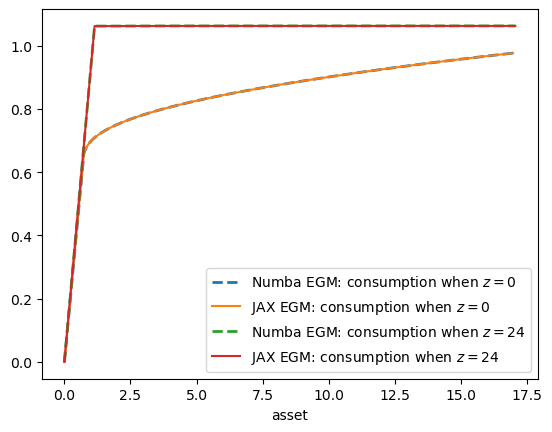

In [24]:
fig, ax = plt.subplots()
β, R, γ, s_grid, y_grid, P = model
s_size, y_size = len(s_grid), len(y_grid)

for z in (0, y_size-1):
    ax.plot(a_star_nb[:, z], 
            σ_star_nb[:, z], 
            '--', lw=2,
            label=f"Numba EGM: consumption when $z={z}$")
    ax.plot(a_star_jax[:, z], 
            σ_star_jax[:, z], 
            label=f"JAX EGM: consumption when $z={z}$")

ax.set_xlabel('asset')
plt.legend()
plt.show()

### Timing

Now let's compare execution time of the two methods

In [25]:
model = ifp()
qe.tic()
a_star_jax, σ_star_jax = successive_approx_jax(model,
                                         print_skip=1000)
jax_time = qe.toc()

Error at iteration 1000 is 6.472028596182788e-05.
Error at iteration 2000 is 1.2994575430580468e-05.

Converged in 2192 iterations.
TOC: Elapsed: 0:00:1.16


In [26]:
model = ifp_numba()
qe.tic()
a_star_nb, σ_star_nb = successive_approx_numba(model,
                                         print_skip=1000)
numba_time = qe.toc()

Error at iteration 1000 is 6.472028596182788e-05.
Error at iteration 2000 is 1.2994575430802513e-05.

Converged in 2192 iterations.
TOC: Elapsed: 0:00:41.61


How much faster is JAX?

In [27]:
numba_time / jax_time

35.831287955063054

The JAX code is significantly faster, as expected.

This difference will increase when more features (and state variables) are added
to the model.

## Exercise

Try replacing `successive_approx_jax` with a jitted version (`@jax.jit` at the top) that uses `jax.lax.while_loop`.

Measure the execution time (after running once to compile) and compare it with the timings above.

Also plot the resulting functions using the plotting code above to make sure that you're still getting the same outputs.

In [28]:
#Put your code here

In [29]:
for i in range(18):
    print("Solution below! 🐘")

Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘
Solution below! 🐘


In [30]:
@jax.jit
def successive_approx_jax_jitted(
                          model,        
                          tol=1e-5,
                          max_iter=100_000,
                          verbose=True,
                          print_skip=25):

    # Unpack
    β, R, γ, s_grid, y_grid, P = model
    s_size, y_size = len(s_grid), len(y_grid)
    
    # Initial condition is to consume all in every state
    σ_init = jnp.repeat(s_grid, y_size)
    σ_init = jnp.reshape(σ_init, (s_size, y_size))
    a_init = jnp.copy(σ_init)

    def update(state):
        i, a_vec, σ_vec, error = state
        a_new, σ_new = K_jax(a_vec, σ_vec, model) 
        error = jnp.max(jnp.abs(σ_vec - σ_new))
        i += 1
        return i, a_new, σ_new, error

    def condition(state):
        i, a_vec, σ_vec, error = state
        return jnp.logical_and(i < max_iter, error > tol)

    init_state = (0, a_init, σ_init, tol + 1)
    state = jax.lax.while_loop(condition, update, init_state)

    return state

Here's a first run.

In [31]:
model = ifp()
i, a_star_jax_jit, σ_star_jax_jit, error = successive_approx_jax_jitted(model,
                                                     print_skip=1000)

In [32]:
print(f"Run completed in {i} iterations with error {error:.5}.")

Run completed in 2192 iterations with error 9.9915e-06.


Now let's time it.

In [33]:
qe.tic()
i, a_star_jax_jit, σ_star_jax_jit, error = successive_approx_jax_jitted(model,
                                                     print_skip=1000)
jax_jit_time = qe.toc()

TOC: Elapsed: 0:00:0.27


In [34]:
jax_time / jax_jit_time

4.290944274354647

In [35]:
numba_time / jax_jit_time

153.75005989353045

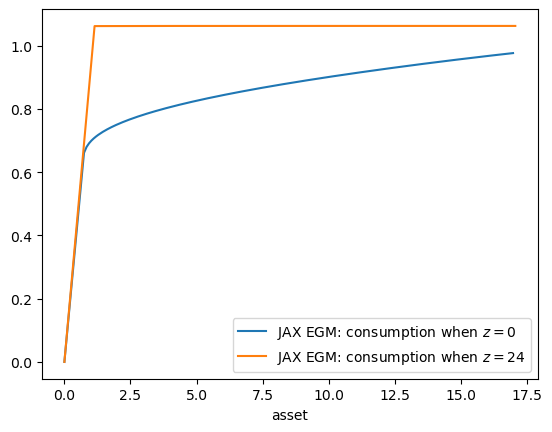

In [36]:
β, R, γ, s_grid, y_grid, P = model
s_size, y_size = len(s_grid), len(y_grid)

fig, ax = plt.subplots()

for z in (0, y_size-1):
    ax.plot(a_star_jax_jit[:, z], 
            σ_star_jax_jit[:, z], 
            label=f"JAX EGM: consumption when $z={z}$")

ax.set_xlabel('asset')
plt.legend()
plt.show()